In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import os

from analysis import plot
from bmtool.util import util
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

model_dir = os.path.join('..', 'V1_bio')
output_dir = os.path.join('..', 'V1_bio_outputs', 'output_drifting')

### File paths

In [2]:
config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')
nodes_file = os.path.join(model_dir, 'network', 'v1_nodes.h5')
node_types_file = os.path.join(model_dir, 'network', 'v1_node_types.csv')

### Load nodes

In [3]:
network_name = 'v1'
v1_nodes = util.load_nodes_from_paths([{"nodes_file": nodes_file, "node_types_file": node_types_file}])[network_name]
v1_nodes = v1_nodes[v1_nodes['model_type'] == 'biophysical'] # choose only biophysical cells

# rename node properties
v1_nodes['layer'] = list(map(lambda x: x[4:], v1_nodes['location']))
e_idx = v1_nodes['ei'] == 'e'
v1_nodes.loc[e_idx, 'pop_name'] = 'e' + v1_nodes.loc[e_idx, 'layer']

In [4]:
# population properties
v1_pop_df = v1_nodes[['pop_name', 'ei', 'layer']].set_index('pop_name')
v1_pop_df = v1_pop_df[~v1_pop_df.index.duplicated(keep='first')]
i_idx = v1_pop_df['ei'] == 'i'
v1_pop_df['cell_type'] = v1_pop_df['ei'] 
v1_pop_df.loc[i_idx, 'cell_type'] = list(map(lambda row: row.Index[len(row.layer) + 1:], v1_pop_df[i_idx].itertuples()))
v1_pop_df['color'] = [plot.pop_color[p] for p in v1_pop_df['cell_type']]
pop_names = v1_pop_df.index.tolist()
display(v1_pop_df)

,ei,layer,cell_type,color
pop_name,,,,
i1Htr3a,i,1,Htr3a,tab:purple
e23,e,23,e,tab:red
i23Htr3a,i,23,Htr3a,tab:purple
i23Pvalb,i,23,Pvalb,tab:blue
i23Sst,i,23,Sst,tab:green
e4,e,4,e,tab:red
i4Htr3a,i,4,Htr3a,tab:purple
i4Pvalb,i,4,Pvalb,tab:blue
i4Sst,i,4,Sst,tab:green


In [5]:
# IDs for raster plot in a reverse order of layers
v1_nodes['raster_id'] = v1_nodes.index
n = len(v1_nodes)
for p in pop_names:
    idx = v1_nodes['pop_name'] == p
    n_pop = idx.sum()
    v1_nodes.loc[idx, 'raster_id'] = range(n - n_pop, n)
    n -= n_pop

### Load spikes

In [6]:
with h5py.File(spikes_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })

In [7]:
# choose only biophysical cells
spikes_bio_df = spikes_df[[nid in v1_nodes.index for nid in spikes_df['node_ids']]].copy()
spikes_bio_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

In [8]:
# spikes of populations
spikes_bio_df[['pop_name', 'raster_id']] = v1_nodes.loc[spikes_bio_df['node_ids'], ['pop_name', 'raster_id']].values
pop_spike = {p: spikes_bio_df.loc[spikes_bio_df['pop_name'] == p] for p in pop_names}

### Raster plot

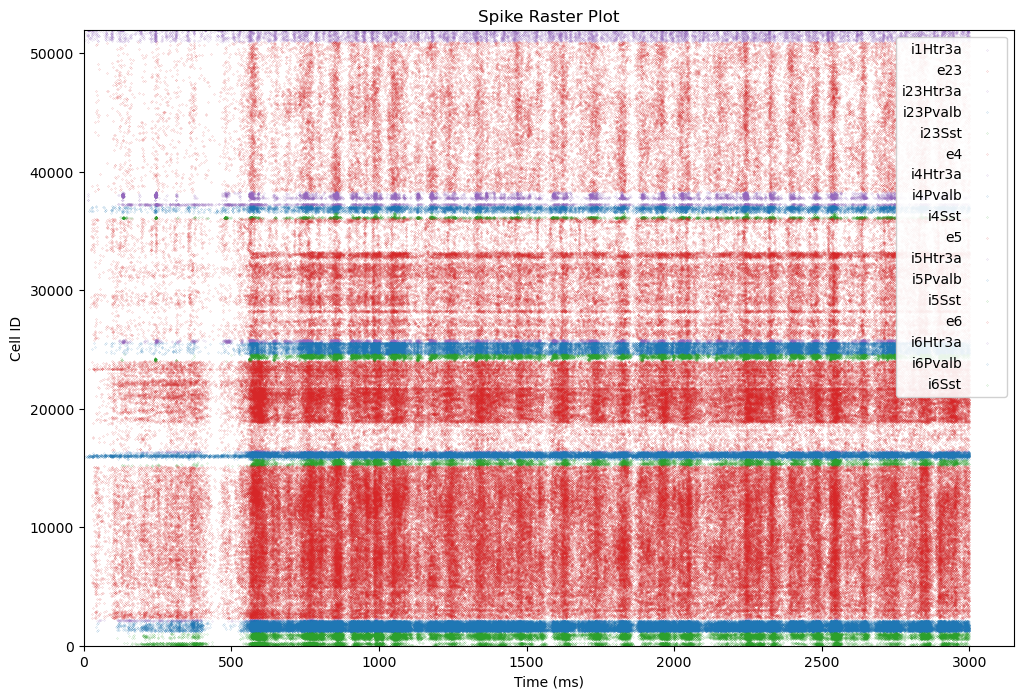

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster(pop_spike, v1_pop_df['color'].to_dict(), id_column='raster_id', s=0.01, ax=ax)
plt.show()

In [10]:
# node_types_df = pd.read_csv(node_types_file, sep=' ')
# group_excludes = node_types_df.loc[node_types_df['model_type'] == 'point_process', 'pop_name'].tolist()

# _ = plot_raster(config_file=config_file, spikes_file=spikes_file,
#                 nodes_file=nodes_file, node_types_file=node_types_file,
#                 group_by='pop_name', group_excludes=group_excludes,
#                 with_histogram=False)

# _ = plot_rates_boxplot(config_file=config_file, spikes_file=spikes_file,
#                        nodes_file=nodes_file, node_types_file=node_types_file,
#                        group_by='pop_name', group_excludes=group_excludes)